# Project 2 Part 6 - Review Classification

### Imports, Preparation

In [28]:
# Imports
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import spacy
import nltk
import joblib

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

# Tensorflow
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers

# Random seed
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)

# Configuration
from sklearn import set_config
set_config(transform_output='pandas')    

In [2]:
%load_ext autoreload
%autoreload 2
import custom_functions as fn

In [3]:
df = joblib.load('data-NLP/reviews_processed.joblib')
df.head(1)

,review_id,movie_id,imdb_id,original_title,review,rating,highlow_rating,tokenized,lemmatized,tokenized_joined,lemmatized_joined
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0,high,"[guilty, pleasure, personally, love, great, es...","[guilty, pleasure, personally, love, great, es...",guilty pleasure personally love great escape w...,guilty pleasure personally love great escape w...


In [4]:
# Drop any reviews that no not have a rating
df.isna().sum()

review_id            0
movie_id             0
imdb_id              0
original_title       0
review               0
rating               0
highlow_rating       0
tokenized            0
lemmatized           0
tokenized_joined     0
lemmatized_joined    0
dtype: int64

In [5]:
# Use original review column as X and classification target column as y
X = df['review']
y = df['highlow_rating']

In [6]:
#Train Test Split
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42)
y_train.value_counts(normalize=True)

low     0.510474
high    0.489526
Name: highlow_rating, dtype: float64

### Part 1 - Machine Learning

#### Build sklearn modeling pipeline with text vectorizer and classification model

In [7]:
## Build text vectorizer and classification model
# Create a sklearn text vectorizer. Consider stopwords, punc, etc.
tfidf_vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
# Create classification model
rf_clf = RandomForestClassifier()

In [8]:
# Create a sklearn modeling pipeline
ml_pipe = Pipeline([('vectorizer', tfidf_vectorizer),
                        ('classifier',rf_clf)])
ml_pipe

Pipeline(steps=[('vectorizer', TfidfVectorizer(stop_words='english')),
                ('classifier', RandomForestClassifier())])

In [9]:
# Fit and evaluate the model using the machine learning classification models from sklearn.
ml_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(stop_words='english')),
                ('classifier', RandomForestClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       1.00      1.00      1.00       888
         low       1.00      1.00      1.00       926

    accuracy                           1.00      1814
   macro avg       1.00      1.00      1.00      1814
weighted avg       1.00      1.00      1.00      1814



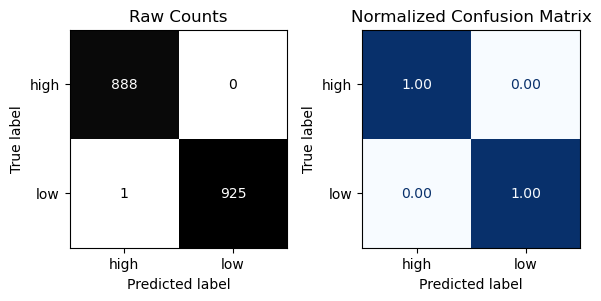


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       0.83      0.87      0.85       307
         low       0.86      0.81      0.83       298

    accuracy                           0.84       605
   macro avg       0.84      0.84      0.84       605
weighted avg       0.84      0.84      0.84       605



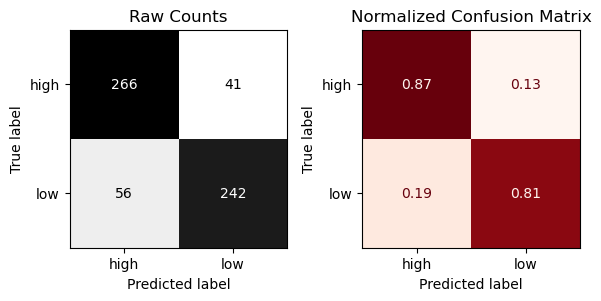

In [10]:
fn.evaluate_classification(ml_pipe, X_train, y_train, X_test, y_test)

- Our model started at 84 % accuracy, and was slightly better at predicting movies with a High rating.

#### Gridsearch Text Vectorization

Try different parameters for our text vectorization layer to try and improve model performance. Begin by finding possible parameters, and creating a grid of parameter options.

In [11]:
## Improve model by tuning preprocessing steps
# Construct grid of params for text vectorization step
# Check possible params
gscv_pipe = Pipeline([('vectorizer', TfidfVectorizer()),
                          ('classifier', RandomForestClassifier())])
gscv_pipe.get_params()

{'memory': None,
 'steps': [('vectorizer', TfidfVectorizer()),
  ('classifier', RandomForestClassifier())],
 'verbose': False,
 'vectorizer': TfidfVectorizer(),
 'classifier': RandomForestClassifier(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.float64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__norm': 'l2',
 'vectorizer__preprocessor': None,
 'vectorizer__smooth_idf': True,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__sublinear_tf': False,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__use_idf': True,
 'vectorizer__vocabulary': None,
 'classifier__bootstrap': True,
 'classifier__ccp_alpha': 0.0,
 'classifier__class_weight

In [12]:
# Define params to try for both vectorizers
param_grid_shared = {
    "vectorizer__max_df": [0.7, 0.8, 0.9],
    'vectorizer__min_df': [ 2, 3, 4 ], 
    "vectorizer__max_features": [None, 1000, 2000],
}

# Define params for the count vectorizer
param_grid_count = {
    'vectorizer':[CountVectorizer()],
    **param_grid_shared,
}

# Define params for tfidf vectorizer 
param_grid_tfidf = {
    'vectorizer': [TfidfVectorizer()],
    "vectorizer__norm": ["l1", "l2"],
    "vectorizer__use_idf": [True, False],
    **param_grid_shared,
}

# Combine into list of params
vect_params_combined = [param_grid_count, param_grid_tfidf]

In [13]:
# Fit and eval grid search results
grid_search = GridSearchCV(gscv_pipe, vect_params_combined, cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 135 candidates, totalling 405 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'vectorizer': [CountVectorizer(max_df=0.7, min_df=3)],
                          'vectorizer__max_df': [0.7, 0.8, 0.9],
                          'vectorizer__max_features': [None, 1000, 2000],
                          'vectorizer__min_df': [2, 3, 4]},
                         {'vectorizer': [TfidfVectorizer()],
                          'vectorizer__max_df': [0.7, 0.8, 0.9],
                          'vectorizer__max_features': [None, 1000, 2000],
                          'vectorizer__min_df': [2, 3, 4],
                          'vectorizer__norm': ['l1', 'l2'],
                          'vectorizer__use_idf': [True, False]}],
             verbose=1)

In [14]:
# What are best params?
grid_search.best_params_

{'vectorizer': CountVectorizer(max_df=0.7, min_df=3),
 'vectorizer__max_df': 0.7,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 3}

Now that we have our best parameters, use them to create a new model and evaluate the performance.

**Evaluate best model**

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       1.00      1.00      1.00       888
         low       1.00      1.00      1.00       926

    accuracy                           1.00      1814
   macro avg       1.00      1.00      1.00      1814
weighted avg       1.00      1.00      1.00      1814



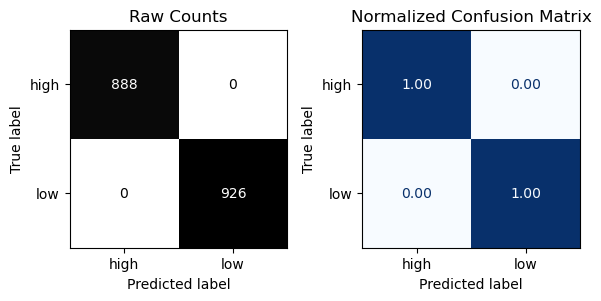


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       0.83      0.85      0.84       307
         low       0.84      0.82      0.83       298

    accuracy                           0.84       605
   macro avg       0.84      0.84      0.84       605
weighted avg       0.84      0.84      0.84       605



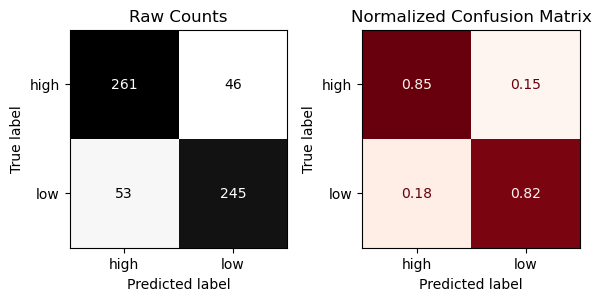

In [15]:
# Define best model
best_model = grid_search.best_estimator_

# Evaluate best model
fn.evaluate_classification(best_model, X_train, y_train, X_test, y_test)

The new model did not perform significantly better than the first, with accuracy staying the same and number of mislabeled movies staying within a couple of the original.

### Part 2 - Deep NLP (RNNs)

#### Creating Train, Test, Validation Datasets

In [20]:
## Convert y to integer values using LabelEncoder()
# Check y values
y.value_counts()

low     1224
high    1195
Name: highlow_rating, dtype: int64

In [25]:
# Convert to integer
labeler = LabelEncoder()
df['highlow_rating'] = labeler.fit_transform(df['highlow_rating'])
y = df['highlow_rating']
y.value_counts()

1    1224
0    1195
Name: highlow_rating, dtype: int64

In [29]:
# Convert to Dataset Object
ds = tf.data.Dataset.from_tensor_slices((X, y))
# Shuffle dataset
ds = ds.shuffle(buffer_size=len(ds), reshuffle_each_iteration=False)

In [30]:
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )
# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)

# Set the batch size
BATCH_SIZE =32
# How many batches? 
import math # math.ceil will round up
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)
print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")

    - train:	1693 samples 	(53 batches)
    - val:  	483 samples 	(16 batches)
    - test: 	243 samples 	(8 batches)


In [34]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)

# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 53 training batches.
 There are 16 validation batches.
 There are 8 testing batches.


#### Creating a Keras Vectorization Layer

In [35]:
# Create keras text vect layer for RNN sequence model
SEQUENCE_LENGTH = 100
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

In [39]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)
# Preview the text
ds_texts.take(1).get_single_element()

<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b"Now that's awesome!\r\n\r\nWhere to start with <em>'Curse of the Golden Flower'</em>? Firstly, I need to show some appreciation for the score - incredible! From the very first scene I knew I was in for a treat in that department, it sets the tone perfectly throughout.\r\n\r\nThis also features outstanding performances from Gong Li (!), Chow Yun-fat, Chen Jin and Jay Chou, among some others. I was particularly impressed by Gong, she truly is terrific from beginning to end - as what is a memorable character. I know I say this a lot with actors, but I'm gonna need to try and check out more of her filmography!\r\n\r\nChow is the only actor in this that I'm familiar with, but this clearly tops what I've seen (not enough, granted) of him thus far - still a fan of him as Sao Feng in <em>'Pirates of the Caribbean: At World's End'</em>, though. The rest of those onscreen, despite the commanding presence of the aforementioned, still manage t

In [40]:
# Train model
sequence_vectorizer.adapt(ds_texts)

In [45]:
# Getting list of vocab
vocab = sequence_vectorizer.get_vocabulary()
int_to_str = {idx: word for idx, word in enumerate(vocab)}

In [41]:
# Programmatically define size of vocab from vectorization layer
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE

24923

In [43]:
## Build an RNN with textVector layer
# build and fit at least 1 sequence model (lstm, gru, bidirectional, etc)


# evaluate model on training and test data




In [44]:
# In markdown, analyze results